In [98]:
import os
import zipfile
import requests
import glob
import sys
import re
import time

import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions as mobile_decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions as inception_decode_predictions

from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import regularizers


%matplotlib inline

In [99]:
#Getting python version
print(sys.version)

3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]


In [100]:
#Getting tensorflow version
tf.__version__

'2.18.0'

In [101]:
#Checking that Tensorflow detects a GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [102]:
if gpus:
    try:
        # Restrict TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [103]:
# Check if the TF_GPU_ALLOCATOR environment variable is set
gpu_allocator = os.environ.get('TF_GPU_ALLOCATOR')

if gpu_allocator is None:
    print("Warning: The TF_GPU_ALLOCATOR environment variable is not set. This variable determines how TensorFlow manages GPU memory allocation."
          "Setting it to 'cuda_malloc_async' can improve performance on NVIDIA GPUs by reducing memory fragmentation during model training. "
          " Please consider setting the variable before running the model (export TF_GPU_ALLOCATOR=cuda_malloc_async)")
else:
    print(f"TF_GPU_ALLOCATOR is set to: {gpu_allocator}")

TF_GPU_ALLOCATOR is set to: cuda_malloc_async


In [104]:
#set mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [105]:
#setting seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [106]:
#hide some warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [107]:
# Start timer to measure execution time
start_time = time.time()

# Download images to train our model

In [108]:
DATASET_DIR = '../dataset/fashion-product-images-small/'
ZIP_FILE_PATH = os.path.join(DATASET_DIR, 'fashion-product-images-small.zip')
DOWNLOAD_URL = 'https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small'

In [109]:
def is_empty_directory(directory):
    return not os.listdir(directory)

In [110]:
if is_empty_directory(DATASET_DIR):
    print("Empty dataset directory. Downloading ZIP File from Kaggle...")
    
    response = requests.get(DOWNLOAD_URL, allow_redirects=True)
    with open(ZIP_FILE_PATH, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Extract the ZIP file
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    print("ZIP file extracted.")

    # Delete the ZIP file after extraction
    os.remove(ZIP_FILE_PATH)
else:
    print("The are images already downloaded. No need to download Zip file from Kaggle")

The are images already downloaded. No need to download Zip file from Kaggle


# EDA

In [111]:
#Load an image
image_path = f'{DATASET_DIR}/images/'
fullname = f'{image_path}/10009.jpg'
img=load_img(fullname, target_size=(224,224))

In [112]:
x=np.array(img)
x.shape

(224, 224, 3)

In [113]:
## Reading informacion about images
CSV_FILE_PATH = F'{DATASET_DIR}/styles.csv'

In [114]:
# Read the first few rows of the CSV to inspect its structure
preview_data = pd.read_csv(CSV_FILE_PATH, nrows=5)
print(preview_data.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2012  Casual             Peter England Men Party Blue Jeans  
2  2016  Casual                       Titan Women Silver Watch  
3  2011  Casual  Manchester United Men Solid Black Track Pants  
4  2012  Casual                          Puma Men Grey T-shirt  


In [115]:
#read dataset and skip some bad lines
columns=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'productDisplayName']
data = pd.read_csv(CSV_FILE_PATH,  usecols=columns, on_bad_lines='skip')
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt


In [116]:
#Adding a new column to dataset, with the file name
data['filename'] = data['id'].astype(str)+'.jpg'
data['filename'] = data['filename'].str.strip() 
data['filename'] = data['filename'].str.lower()  
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt,53759.jpg


In [117]:
IMAGES_DIR = f'{DATASET_DIR}/images'

In [118]:
# Checking for invalid filenames and getting information about images
invalid_filenames = []
image_sizes = []
all_images = []
for filename in data['filename']:
    file_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(file_path):
        invalid_filenames.append(filename)
    else:
        img = Image.open(file_path)
        image_sizes.append(img.size)
print("Invalid filenames:\n")
for invalid in invalid_filenames:
    print(invalid)


Invalid filenames:

39403.jpg
39410.jpg
39401.jpg
39425.jpg
12347.jpg


In [119]:
# Checking for images which information might not be on the dataset 
all_images = set(os.listdir(IMAGES_DIR))
dataset_filenames = set(data['filename'])
orphaned_images = all_images-dataset_filenames
if orphaned_images:
    print("\nOrphaned images (not in the dataset):\n")
    for img in orphaned_images:
        print(img)
else:
    print("\nAll images in the directory have corresponding entries in the dataset.")


All images in the directory have corresponding entries in the dataset.


In [120]:
#There are some missing images, we will just erase their information from the dataset
data_cleaned = data[~data['filename'].isin(invalid_filenames)]
print(f'Total images that will be used as input: {len(data_cleaned)}')

Total images that will be used as input: 44441


Displaying image corresponding to the article 'Turtle Check Men Navy Blue Shirt' of type 'Shirts'


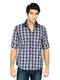

In [121]:
#Load one of the images to check is dimensions
sample_image_filename = data.iloc[0].filename
sample_image_fullname = f'{IMAGES_DIR}/{sample_image_filename}'
sample_image_displayName =  data.iloc[0].productDisplayName
sample_image_articleType = data.iloc[0].articleType
img = load_img(sample_image_fullname)

print(f'Displaying image corresponding to the article \'{sample_image_displayName}\' of type \'{sample_image_articleType}\'')
img

In [122]:
x=np.array(img)
x.shape

(80, 60, 3)

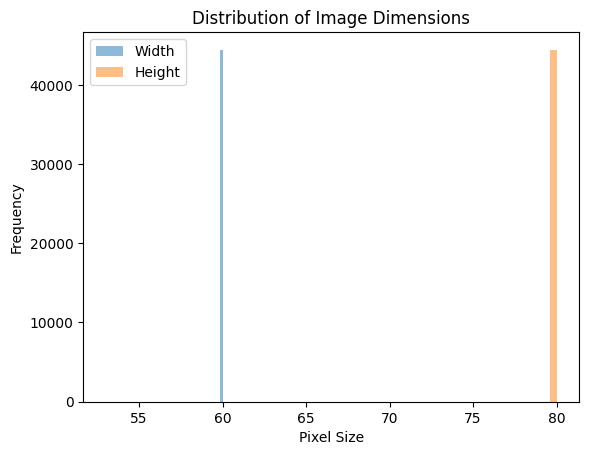

In [123]:
#Analyzing distribution of image dimensions
width, height = zip(*image_sizes)
plt.hist(width, bins=50, alpha=0.5, label='Width')
plt.hist(height, bins=50, alpha=0.5, label='Height')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

In [124]:
# Conclusion: All the images have a size of 60x80

In [125]:
#Analyzing how many articles are there per class
sub_category_counts =data.groupby('articleType').size().reset_index(name='count')
sub_category_counts.sort_values(by='count', ascending=True)

,articleType,count
10,Body Wash and Scrub,1
26,Cushion Covers,1
54,Ipad,1
46,Hair Accessory,1
106,Shoe Laces,1
...,...,...
112,Sports Shoes,2036
140,Watches,2542
19,Casual Shoes,2846
104,Shirts,3217


In [126]:
# Conclusion: There are some categories for which we have very few samples

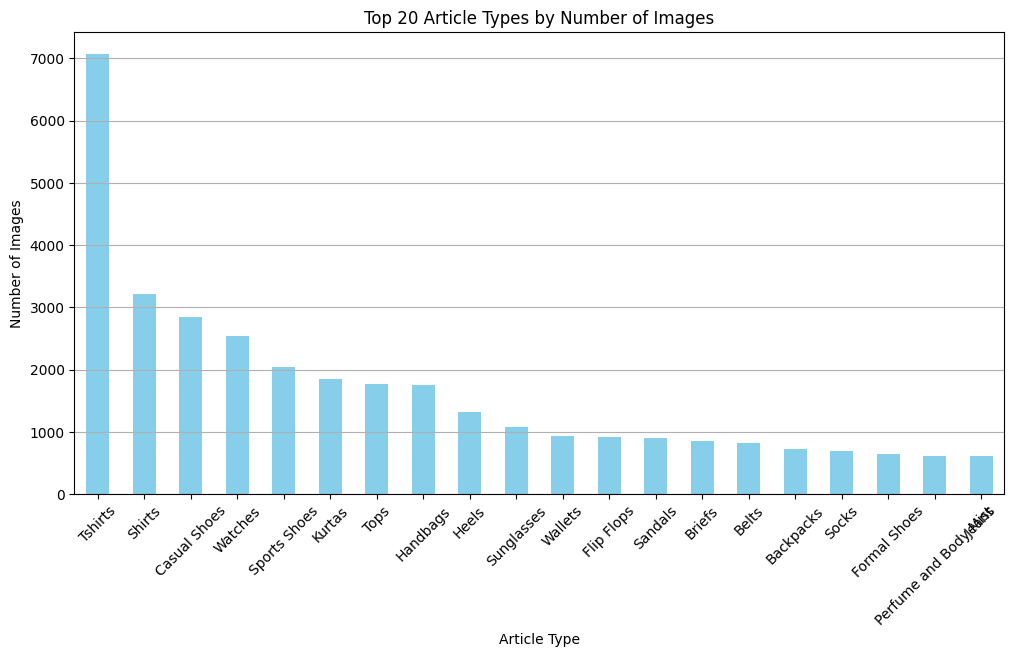

In [127]:
#Plotting the classes with a large number of items
class_counts = data['articleType'].value_counts()
top_20_classes = class_counts.head(20)

plt.figure(figsize=(12, 6))
top_20_classes.plot(kind='bar', color='skyblue')

plt.title('Top 20 Article Types by Number of Images')
plt.xlabel('Article Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  
plt.grid(axis='y')

plt.show()


In [128]:
# Filter the article types to keep only those with more than 4 samples 
#(we need at least 1 sample in each dataframe: train, val and test and with a small quantity of samples, it is difficult to achieve)
valid_article_types = sub_category_counts[sub_category_counts['count'] >= 4]['articleType']
data_cleaned = data_cleaned[data_cleaned['articleType'].isin(valid_article_types)]

In [129]:
count_classes_in_dataframe = data_cleaned['articleType'].nunique()
count_classes_in_dataframe

128

In [130]:
#split the data into training, validation and test datasets
full_train_df, test_df = train_test_split(data_cleaned, test_size=0.2, random_state=42, stratify=data_cleaned['articleType'])
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=42, stratify=full_train_df['articleType'])

In [131]:
# Summary of the splits
print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("Test Data Shape:", test_df.shape)

Training Data Shape: (26649, 7)
Validation Data Shape: (8883, 7)
Test Data Shape: (8883, 7)


In [132]:
print("Unique classes in training dataset:")
print(train_df['articleType'].value_counts())

print("\nUnique classes in validation dataset:")
print(val_df['articleType'].value_counts())

print("\nUnique classes in test dataset:")
print(test_df['articleType'].value_counts())


Unique classes in training dataset:
articleType
Tshirts             4241
Shirts              1929
Casual Shoes        1708
Watches             1525
Sports Shoes        1222
                    ... 
Beauty Accessory       2
Makeup Remover         2
Lip Plumper            2
Robe                   2
Lehenga Choli          2
Name: count, Length: 128, dtype: int64

Unique classes in validation dataset:
articleType
Tshirts            1414
Shirts              643
Casual Shoes        569
Watches             508
Sports Shoes        407
                   ... 
Lehenga Choli         1
Eye Cream             1
Nail Essentials       1
Umbrellas             1
Nehru Jackets         1
Name: count, Length: 128, dtype: int64

Unique classes in test dataset:
articleType
Tshirts             1414
Shirts               643
Casual Shoes         569
Watches              509
Sports Shoes         407
                    ... 
Wristbands             1
Headband               1
Lehenga Choli          1
Beauty Accesso

# Transfering learning

## Preparing input for Model v1 with MobileNetV2

In [133]:
# defining a target size for images
TARGET_SIZE = (320, 320)
#defining a batch size
BATCH_SIZE=16
#defining a max queue size (count of batches preloaded in the queue while the model is training)
MAX_QUEUE_SIZE=10

In [134]:
# calculating how many workers threads for loading data
##warning: it is not certain that these parameters are being used by the ImageDataGenerator
num_cores = os.cpu_count()
workers = int(num_cores / 2)
use_multiprocessing=False
if workers>1:
   use_multiprocessing=True

In [135]:
#Read images by using ImageDataGenerator (we will use the articleType as our class)
train_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [136]:
val_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
val_gen = val_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False,
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8883 validated image filenames belonging to 128 classes.


In [137]:
generated_classes = list(train_gen.class_indices.keys())
classes_in_dataframe = list(train_gen.class_indices.keys())
if set(classes_in_dataframe) == set(generated_classes):
    print("\nThe classes in train_df match the classes in the ImageDataGenerator.")
else:
    print("\nThere is a mismatch between the classes!")
    print("Classes in train_df:", classes_in_dataframe)
    print("Classes from ImageDataGenerator:", generated_classes)


The classes in train_df match the classes in the ImageDataGenerator.


In [138]:
class_indices = train_gen.class_indices
class_indices

{'Accessory Gift Set': 0,
 'Baby Dolls': 1,
 'Backpacks': 2,
 'Bangle': 3,
 'Basketballs': 4,
 'Bath Robe': 5,
 'Beauty Accessory': 6,
 'Belts': 7,
 'Blazers': 8,
 'Body Lotion': 9,
 'Booties': 10,
 'Boxers': 11,
 'Bra': 12,
 'Bracelet': 13,
 'Briefs': 14,
 'Camisoles': 15,
 'Capris': 16,
 'Caps': 17,
 'Casual Shoes': 18,
 'Churidar': 19,
 'Clothing Set': 20,
 'Clutches': 21,
 'Compact': 22,
 'Concealer': 23,
 'Cufflinks': 24,
 'Deodorant': 25,
 'Dresses': 26,
 'Duffel Bag': 27,
 'Dupatta': 28,
 'Earrings': 29,
 'Eye Cream': 30,
 'Eyeshadow': 31,
 'Face Moisturisers': 32,
 'Face Scrub and Exfoliator': 33,
 'Face Wash and Cleanser': 34,
 'Flats': 35,
 'Flip Flops': 36,
 'Footballs': 37,
 'Formal Shoes': 38,
 'Foundation and Primer': 39,
 'Fragrance Gift Set': 40,
 'Free Gifts': 41,
 'Gloves': 42,
 'Hair Colour': 43,
 'Handbags': 44,
 'Headband': 45,
 'Heels': 46,
 'Highlighter and Blush': 47,
 'Innerwear Vests': 48,
 'Jackets': 49,
 'Jeans': 50,
 'Jeggings': 51,
 'Jewellery Set': 52,
 '

In [139]:
count_classes = len(class_indices)
print (f'Category count:  {count_classes}')

Category count:  128


In [140]:
#Checking size of images and batches

train_batch_images_train, train_batch_labels = next(train_gen)  
if train_batch_labels.shape[1] == count_classes_in_dataframe:
    print("Training labels match the expected number of classes: OK")
else:
    print(f"Error: Training labels do not match the expected number of classes! Expected {count_classes_in_dataframe}, got {train_batch_labels.shape[1]}.")
print("Batch shape for training:", train_batch_images_train.shape) 


val_batch_images, val_batch_labels = next(val_gen)  
if val_batch_labels.shape[1] == count_classes_in_dataframe:
    print("Validation labels match the expected number of classes: OK")
else:
    print(f"Error: Validation labels do not match the expected number of classes! Expected {count_classes_in_dataframe}, got {val_batch_labels.shape[1]}.")
print("Batch shape for validation:", val_batch_images.shape) 


Training labels match the expected number of classes: OK
Batch shape for training: (16, 320, 320, 3)
Validation labels match the expected number of classes: OK
Batch shape for validation: (16, 320, 320, 3)


In [141]:
# Initialize a dictionary to store results for each model
model_results = {}

## Create Model v1 with MobileNetV2

In [75]:
def make_model_Mobile_v1(learning_rate=0.01):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    #dense layer
    outputs = keras.layers.Dense(count_classes, activation='softmax')(vectors)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [76]:
model = make_model_Mobile_v1()
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

I0000 00:00:1735963717.864537  219815 service.cc:148] XLA service 0x36545300 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735963717.867896  219815 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1735963718.148802  219815 service.cc:148] XLA service 0x7f04a0049350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735963718.148829  219815 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
I0000 00:00:1735963718.287174  219815 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1735963718.289494  219815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2245 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/10


2025-01-03 23:08:44.679988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735963724.845787  325248 cuda_dnn.cc:529] Loaded cuDNN version 90600


  6/833 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.1023 - loss: 11.3601 

I0000 00:00:1735963729.386713  325248 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/833 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5051 - loss: 7.3434   

2025-01-03 23:09:06.763553: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[25,32,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,81,81]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-03 23:09:06.768195: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.691579693s
Trying algorithm eng0{} for conv (f32[25,32,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,81,81]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_

833/833 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - accuracy: 0.5645 - loss: 6.5250 - val_accuracy: 0.6723 - val_loss: 5.7660
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7271 - loss: 4.1379 - val_accuracy: 0.7125 - val_loss: 5.4230
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7677 - loss: 3.4946 - val_accuracy: 0.6992 - val_loss: 7.0318
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.7958 - loss: 3.1914 - val_accuracy: 0.7479 - val_loss: 5.8895
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8161 - loss: 2.9351 - val_accuracy: 0.7327 - val_loss: 6.7927
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.8265 - loss: 2.7377 - val_accuracy: 0.7271 - val_loss: 7.8213
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8302 - loss: 2.7713 - val_accuracy: 0.7370 - val_loss: 7.1105
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8401 - loss: 2.4605 - val_accurac

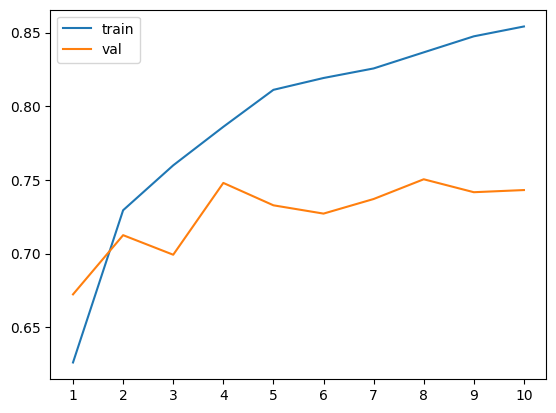

In [77]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

In [48]:
## Conclusion: the model overfits the training data. Accuracy for validation dataset does not surpasses 80%

## Create Model v1 with InceptionV3

## Preparing input for Model v1 with InceptionV3

In [49]:
#Read images by using ImageDataGenerator (we will use the articleType as our class)
train_image_gen = ImageDataGenerator(preprocessing_function=inception_preprocess_input)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [50]:
val_image_gen = ImageDataGenerator(preprocessing_function=inception_preprocess_input)
val_gen = val_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False,
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8883 validated image filenames belonging to 128 classes.


In [51]:
def make_model_Inception_v1(learning_rate=0.01):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    #dense layer
    outputs = keras.layers.Dense(count_classes, activation='softmax')(vectors)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [52]:
model = make_model_Inception_v1()
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
801/833 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5277 - loss: 5.2213 

2024-12-30 22:43:06.025243: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[19,192,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,768,4,4]{3,2,1,0}, f32[192,768,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-30 22:43:06.028609: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.671418877s
Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[19,192,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,768,4,4]{3,2,1,0}, f32[192,768,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{

833/833 ━━━━━━━━━━━━━━━━━━━━ 52s 49ms/step - accuracy: 0.5300 - loss: 5.2117 - val_accuracy: 0.6601 - val_loss: 4.9024
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.7067 - loss: 3.2826 - val_accuracy: 0.6686 - val_loss: 5.0049
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.7423 - loss: 2.8127 - val_accuracy: 0.6840 - val_loss: 6.4371
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.7680 - loss: 2.5376 - val_accuracy: 0.6831 - val_loss: 6.3555
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.7938 - loss: 2.1285 - val_accuracy: 0.6838 - val_loss: 6.5699
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.8114 - loss: 2.0002 - val_accuracy: 0.6921 - val_loss: 6.0946
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.8215 - loss: 1.8587 - val_accuracy: 0.6977 - val_loss: 6.9588
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.8395 - loss: 1.6840 - val_accurac

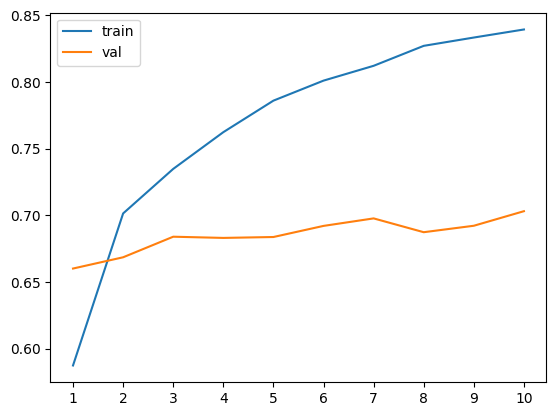

In [53]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

In [54]:
#Conclusion: the Mobile model performs better than the Inception model, and the latter one is slower
## so, the base layer of the model used in this project will be based on MobileNetV2

### Adjusting learning rate for Model version 1

In [78]:
scores={}
print("Training with different learning rates:\n")
for lr in [0.0001, 0.0005, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model_Mobile_v1(learning_rate=lr)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)
    scores[lr]= history.history

    print()
    print()

Training with different learning rates:

0.0001
Epoch 1/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.3267 - loss: 3.1930 - val_accuracy: 0.6482 - val_loss: 1.3316
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.6788 - loss: 1.1900 - val_accuracy: 0.7092 - val_loss: 1.0423
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7352 - loss: 0.9351 - val_accuracy: 0.7380 - val_loss: 0.9258
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.7617 - loss: 0.8041 - val_accuracy: 0.7511 - val_loss: 0.8630
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.7861 - loss: 0.7038 - val_accuracy: 0.7634 - val_loss: 0.8180
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.8009 - loss: 0.6541 - val_accuracy: 0.7689 - val_loss: 0.7873
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8151 - loss: 0.6058 - val_accuracy: 0.7771 - val_loss: 0.7623
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 23

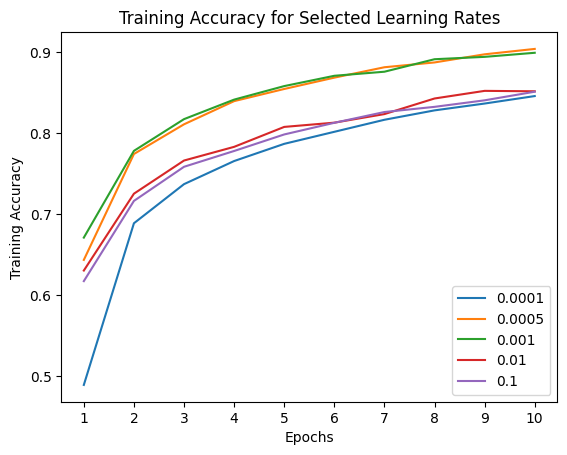

In [79]:
#Plotting the train accuracy
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)

plt.title('Training Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

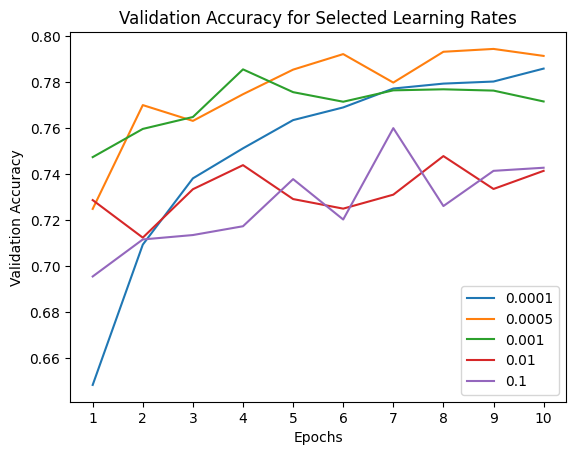

In [80]:
#Plotting the validation accuracy
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

    
plt.title('Validation Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

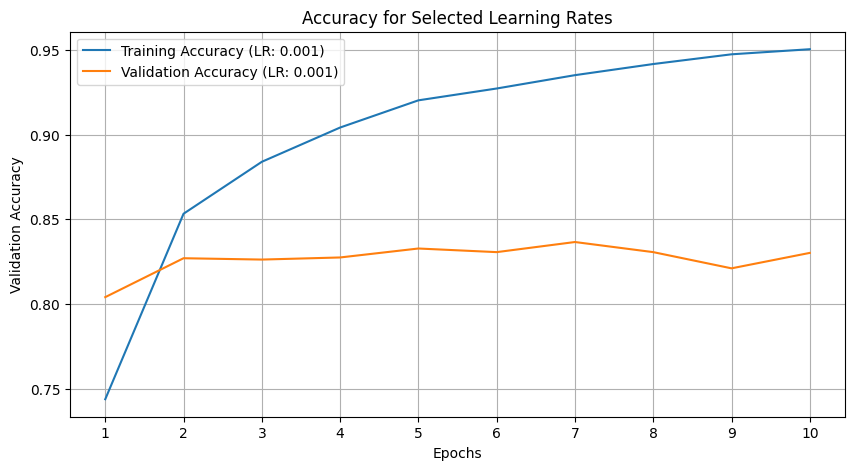

In [58]:
#Plotting validation and train accuracy only for learning rate 0.001
lr=0.001
hist = scores[lr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (LR: {lr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (LR: {lr})')

plt.title('Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

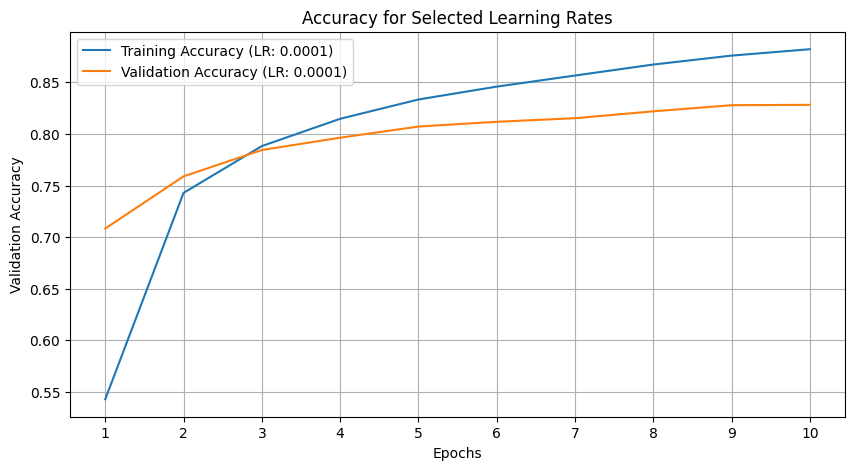

In [59]:
#Plotting validation and train accuracy only for learning rate 0.0001
lr=0.0001
hist = scores[lr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (LR: {lr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (LR: {lr})')

plt.title('Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

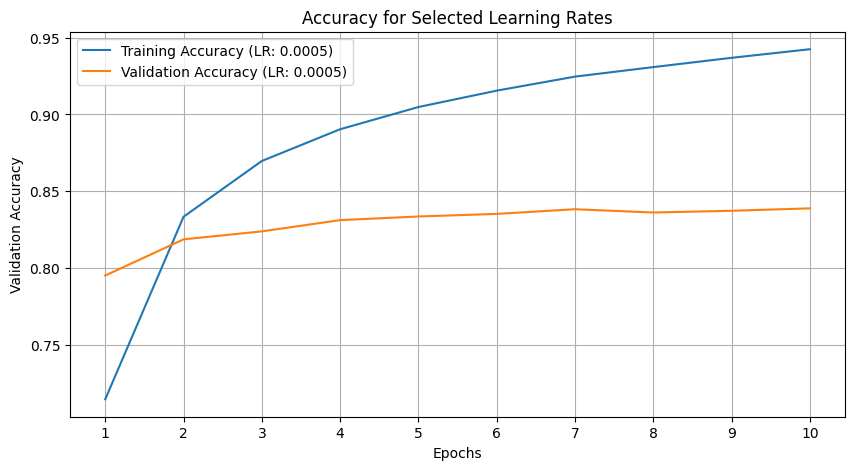

In [60]:
#Plotting validation and train accuracy only for learning rate 0.0005
lr=0.0005
hist = scores[lr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (LR: {lr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (LR: {lr})')

plt.title('Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [48]:
#Conclusion: The model takes longer to learn with a rate of 0.0001, but the validation and training accuracies are closer together 
#Besides that, does not overfit and after 5 epochs we already have 80% accuracy or better
best_learning_rate=0.0001

In [49]:
MODELS_DIR = '../models'

In [50]:
#Defining function to delete any previously saved files
def delete_previous_checkpoint_files(filename_pattern):
    # Compile the regex pattern
    regex = re.compile(filename_pattern)
    
    # List all files in the specified directory
    files = os.listdir(MODELS_DIR)

    # Filter files matching the regex pattern
    matching_files = [f for f in files if regex.match(f)]
    
    # Check if there are matching files
    if not matching_files:
        print("No matching files found for deletion.")
        return 

    # Iterate through the matching files and delete them
    for checkpoint_file in matching_files:
        full_file_path = os.path.join(MODELS_DIR, checkpoint_file)
        try:
            os.remove(full_file_path)  # Attempt to delete the file
            print(f"Deleted checkpoint file: {checkpoint_file}")
        except Exception as e:
            print(f"Error deleting file {full_file_path}: {e}")

In [51]:
#Define class for a custom checkpoint
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_accuracy = 0.0
        self.best_model_file = ""

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)  # Call the parent method
        current_val_accuracy = logs.get('val_accuracy')

        if current_val_accuracy > self.best_accuracy:
            # Update best values
            self.best_accuracy = current_val_accuracy
            self.best_model_file = self.filepath.format(epoch=epoch+1, **logs)
            print(f"New best model saved at epoch {epoch+1} with validation accuracy {self.best_accuracy:.3f}.Filename:{self.best_model_file}")

In [ ]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v1.*\.keras')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v1_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

learning_rate=best_learning_rate
print(f'\nTraining the model with learning rate {learning_rate}\n')
model = make_model_Mobile_v1(learning_rate=learning_rate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)

Deleting files previously saved to output directory

No matching files found for deletion.

Training the model with learning rate 0.0001

Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.718.Filename:../models/Mobile_v1_01_0.718.keras.4757 
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.4336 - loss: 2.4752 - val_accuracy: 0.7182 - val_loss: 1.0050
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.763.Filename:../models/Mobile_v1_02_0.763.keras.8957 
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.7348 - loss: 0.8957 - val_accuracy: 0.7633 - val_loss: 0.8094
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.781.Filename:../models/Mobile_v1_03_0.781.keras.6838 
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.7882 - loss: 0.6838 - val_accuracy: 0.7808 - val_loss: 0.7337
Epoch 4/10
New best model saved at epoch 4 with validation accuracy 0.793.Filename:../models/Mobile_v1_04_0.793.keras.5926 
166

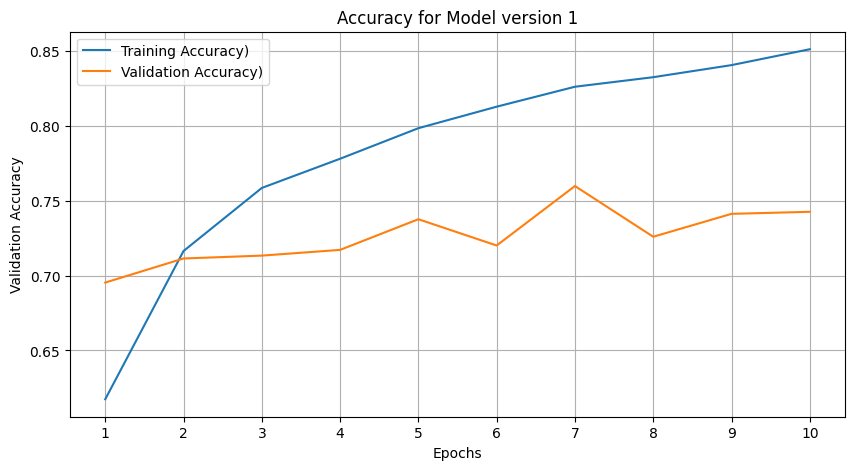

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy)')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy)')

plt.title('Accuracy for Model version 1')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [87]:
print(f"Best Validation Accuracy for 'Mobile version 1' model: {round(custom_checkpoint.best_accuracy, 4)}")
print(f"Saved Model File: {custom_checkpoint.best_model_file}")

Best Validation Accuracy for 'Mobile version 1' model: 0.7825
Saved Model File: ../models/Mobile_v1_10_0.783.keras


In [88]:
#Even when the best accuracy is achieved later in the training, I will select the model at epoch 4, because there is a smaller
#gap between the training accuracy and the validation accuracy and the validation accuracy is not bad, it is over 80%

#build checkpoint file name for epoch 5
epoch=5
epoch_index = epoch-1  #the epochs are 0 indexed
val_accuracy = history.history['val_accuracy'][epoch_index]  
checkpoint_filename = f'Mobile_v1_{epoch:02d}_{val_accuracy:.3f}.keras'

#verify that the file exists
checkpoint_file_path = os.path.join(MODELS_DIR, checkpoint_filename)

# Check if the file exists
if not os.path.isfile(checkpoint_file_path):
    print(f"Checkpoint file does not exist: {checkpoint_file_path}")
    checkpoint_filename='not found'

#store results for model version 1
model_results['mobile_v1'] = {
    'accuracy': round(val_accuracy, 4),
    'filename': checkpoint_filename
}

In [89]:
model_results['mobile_v1']

{'accuracy': 0.7627, 'filename': 'Mobile_v1_05_0.763.keras'}

## Create Model version 2 by adding another inner layer

In [52]:
def make_model_Mobile_v2(learning_rate, inner_layer_units):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu')(vectors)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(inner)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

### Find the best inner layer size

In [53]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v2_size.*\.keras')
print(f'Training the model with different sizes for the inner layer \n')

scores={}
for size in [count_classes*2, count_classes*3, count_classes*5, count_classes*10, count_classes*20]:
    print(f'Fitting model for size {size}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v2_size{size}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v2(learning_rate=best_learning_rate, inner_layer_units=size)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[size] = history.history
    print()
    print()

Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v2_size256_01_0.753.keras
Deleted checkpoint file: Mobile_v2_size256_02_0.785.keras
Deleted checkpoint file: Mobile_v2_size256_03_0.798.keras
Training the model with different sizes for the inner layer 

Fitting model for size 256


I0000 00:00:1736008920.201823  405292 service.cc:148] XLA service 0x27aec0c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736008920.201932  405292 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1736008920.462560  405292 service.cc:148] XLA service 0x2091c450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736008920.462579  405292 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
I0000 00:00:1736008920.474984  405292 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1736008920.478325  405292 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2245 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/10


2025-01-04 11:42:05.965525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736008926.796516  405479 cuda_dnn.cc:529] Loaded cuDNN version 90600


  14/1666 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.0049 - loss: 5.4114      

I0000 00:00:1736008930.787841  405479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


New best model saved at epoch 1 with validation accuracy 0.762.Filename:../models/Mobile_v2_size256_01_0.762.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.5524 - loss: 2.0489 - val_accuracy: 0.7620 - val_loss: 0.8814
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.792.Filename:../models/Mobile_v2_size256_02_0.792.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.7786 - loss: 0.7702 - val_accuracy: 0.7921 - val_loss: 0.7313
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.793.Filename:../models/Mobile_v2_size256_03_0.793.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8230 - loss: 0.5921 - val_accuracy: 0.7929 - val_loss: 0.6909
Epoch 4/10
New best model saved at epoch 4 with validation accuracy 0.800.Filename:../models/Mobile_v2_size256_04_0.800.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8539 - loss: 0.4803 - val_accuracy: 0.8004 - val_loss: 0.6562
Epoch 5/10
New best mod

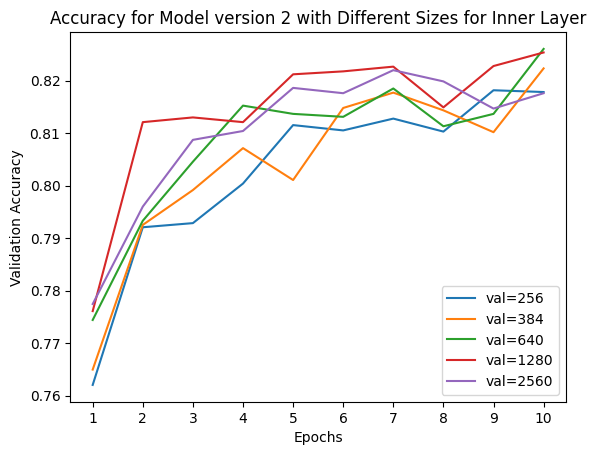

In [55]:
#Plotting the results
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.title('Accuracy for Model version 2 with Different Sizes for Inner Layer')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

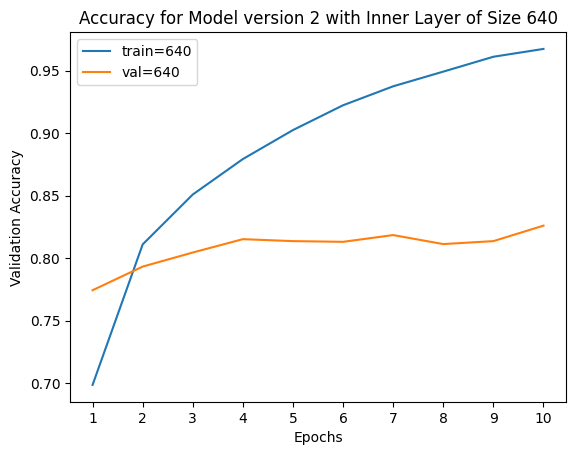

In [57]:
#Plotting training and validation accuracy for model with inner lazyer of size 640
size = 640
hist = scores[size]
plt.plot(hist['accuracy'], label=('train=%s' % size))
plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.title(f'Accuracy for Model version 2 with Inner Layer of Size {size}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

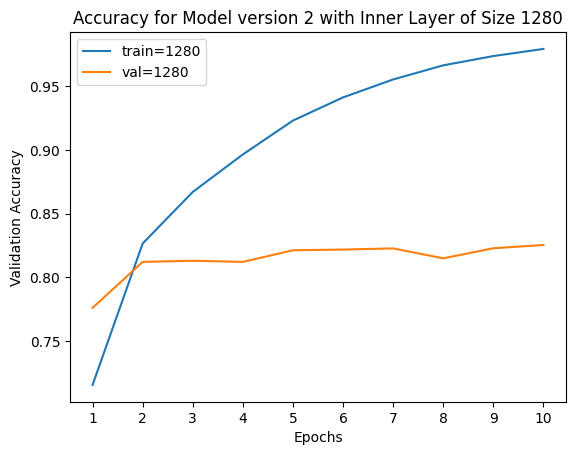

In [60]:
#Plotting training and validation accuracy for model with inner lazyer of size 1280
size = 1280
hist = scores[size]
plt.plot(hist['accuracy'], label=('train=%s' % size))
plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.title(f'Accuracy for Model version 2 with Inner Layer of Size {size}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

In [ ]:
##Conclusion, the model overfits, after the second epoch the gap between train accuracy and validation accuracy increases

In [61]:
#Building a resume with the results
best_models_info = {}

for size in scores.keys():
    best_val_accuracy = max(scores[size]['val_accuracy'])
    
    checkpoint_filename_pattern = f'Mobile_v2_size{size}_*_{best_val_accuracy:.3f}.keras'
    checkpoint_files = glob.glob(os.path.join(MODELS_DIR, checkpoint_filename_pattern))
    
    if checkpoint_files:
        best_models_info[size] = {
            'best_accuracy': best_val_accuracy,
            'checkpoint_file': checkpoint_files[0]  # Get the first matching file
        }
    else:
        print(f"No checkpoint files found for size {size} with accuracy {best_val_accuracy:.3f}")

for size, info in best_models_info.items():
    print(f"Best model for inner layer size {size}:")
    print(f"Best Validation Accuracy: {info['best_accuracy']:.3f}")
    print(f"Checkpoint file: {info['checkpoint_file']}")        

Best model for inner layer size 256:
Best Validation Accuracy: 0.818
Checkpoint file: ../models/Mobile_v2_size256_09_0.818.keras
Best model for inner layer size 384:
Best Validation Accuracy: 0.822
Checkpoint file: ../models/Mobile_v2_size384_10_0.822.keras
Best model for inner layer size 640:
Best Validation Accuracy: 0.826
Checkpoint file: ../models/Mobile_v2_size640_10_0.826.keras
Best model for inner layer size 1280:
Best Validation Accuracy: 0.825
Checkpoint file: ../models/Mobile_v2_size1280_10_0.825.keras
Best model for inner layer size 2560:
Best Validation Accuracy: 0.822
Checkpoint file: ../models/Mobile_v2_size2560_07_0.822.keras


In [66]:
# Conclusion: The inner layer size of 640 provides the best accuracy, but the model still overfits
best_inner_layer_size=640
epoch=10
val_accuracy = max(scores[best_inner_layer_size]['val_accuracy'])
checkpoint_filename = f'Mobile_v2_size{best_inner_layer_size}_{epoch:02d}_{val_accuracy:.3f}.keras'

#verify that the file exists
checkpoint_file_path = os.path.join(MODELS_DIR, checkpoint_filename)

# Check if the file exists
if not os.path.isfile(checkpoint_file_path):
    print(f"Checkpoint file does not exist: {checkpoint_file_path}")
    checkpoint_filename='not found'

#store results for model version 2
model_results['mobile_v2'] = {
    'accuracy': round(val_accuracy, 4),
    'filename': checkpoint_filename
}

In [67]:
print(f"Best Validation Accuracy for 'Mobile version 2' model: {round(best_models_info[best_inner_layer_size]['best_accuracy'], 4)}")
print(f"Saved Model File: {best_models_info[best_inner_layer_size]['checkpoint_file']}")

Best Validation Accuracy for 'Mobile version 2' model: 0.8261
Saved Model File: ../models/Mobile_v2_size640_10_0.826.keras


In [68]:
model_results['mobile_v2']

{'accuracy': 0.8261, 'filename': 'Mobile_v2_size640_10_0.826.keras'}

### Creating Mobile Model version 3 by adding l2 regularization

In [81]:
def make_model_Mobile_v3(learning_rate, inner_layer_units, regularization_factor):
    
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu', 
                               kernel_regularizer=keras.regularizers.L2(regularization_factor))(vectors)
   
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(inner)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [71]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v3_l2.*\.keras')
print(f'Training the model with different regularization factors for the inner layer \n')

learning_rate=best_learning_rate
inner_layer_size=best_inner_layer_size
factors = [0.0001, 0.001, 0.01, 0.1]
scores={}
for factor in factors:
    print(f'Fitting model for regularization factor {factor}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v3_l2reg{factor}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=False,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v4(learning_rate=learning_rate, inner_layer_units=inner_layer_size, regularization_factor=factor)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[factor] = history.history
    print()
    print()

Deleting files previously saved to output directory

No matching files found for deletion.
Training the model with different regularization factors for the inner layer 

Fitting model for regularization factor 0.0001
Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.777.Filename:../models/Mobile_v4_l2reg0.0001_01_0.777.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.6106 - loss: 1.7953 - val_accuracy: 0.7770 - val_loss: 0.8560
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.789.Filename:../models/Mobile_v4_l2reg0.0001_02_0.789.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8068 - loss: 0.7342 - val_accuracy: 0.7893 - val_loss: 0.7758
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.802.Filename:../models/Mobile_v4_l2reg0.0001_03_0.802.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8526 - loss: 0.5560 - val_accuracy: 0.8018 - val_loss: 0.7478
Epoch 4/10
New best model save

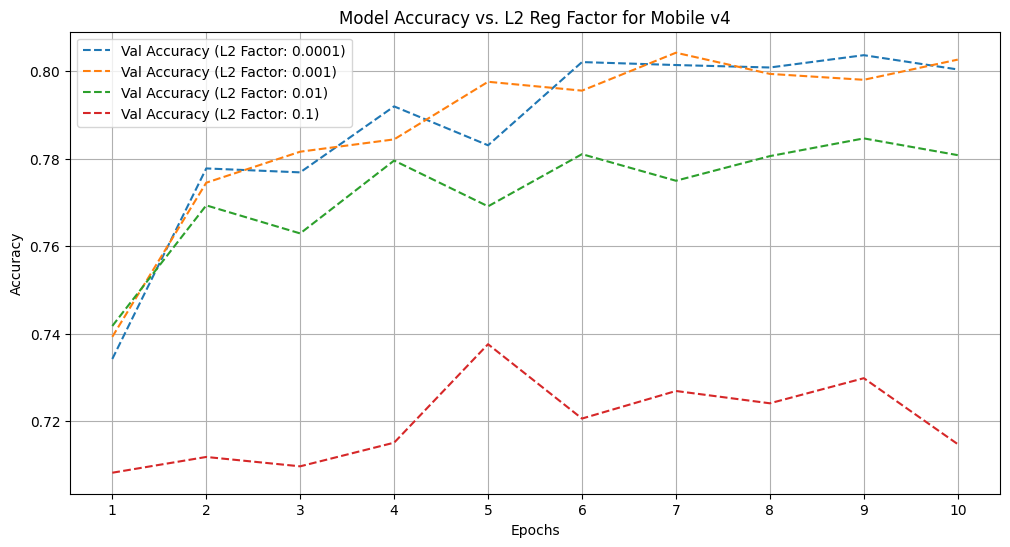

In [106]:
# Plotting the results
plt.figure(figsize=(12, 6))
for factor in factors:
    plt.plot(scores[factor]['val_accuracy'], label=f'Val Accuracy (L2 Factor: {factor})', linestyle='--')

plt.title('Model Accuracy vs. L2 Reg Factor for Mobile v3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

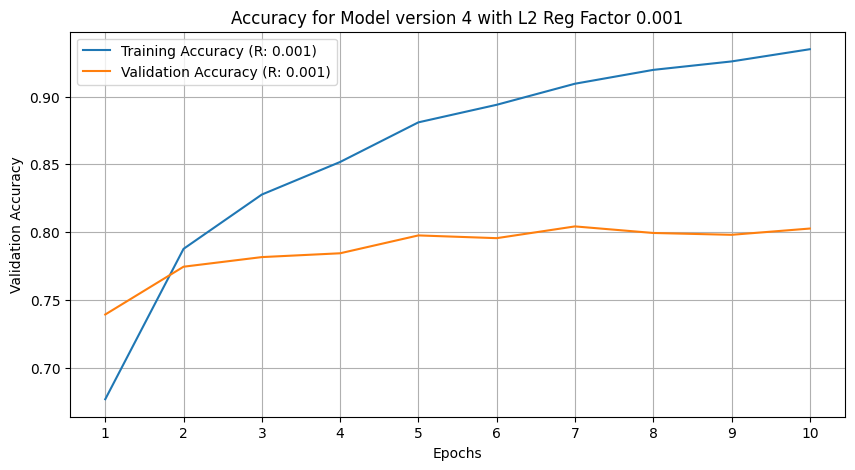

In [107]:
#Plotting training and validation accuracy for regularization=0.001
r=0.001
hist = scores[r]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (R: {r})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (R: {r})')

plt.title(f'Accuracy for Model version 3 with L2 Reg Factor {r}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

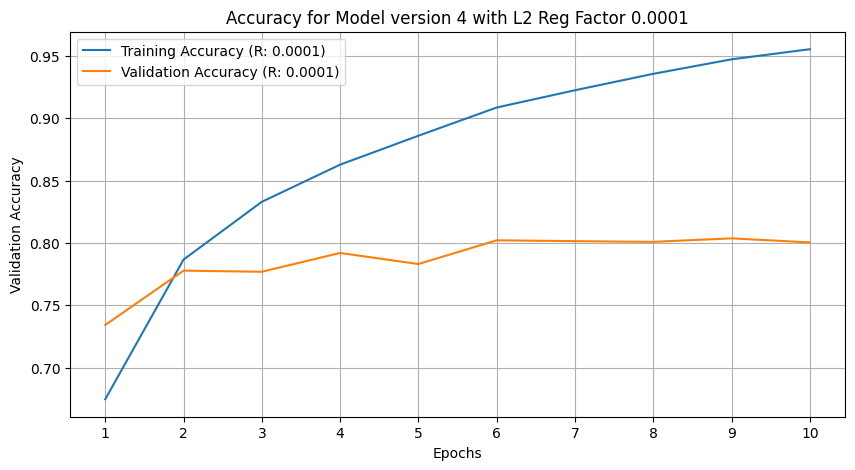

In [108]:
#Plotting training and validation accuracy for regularization=0.0001
r=0.0001
hist = scores[r]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (R: {r})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (R: {r})')

plt.title(f'Accuracy for Model version 3 with L2 Reg Factor {r}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [113]:
##Conclusion: for all the l2 regularization rates the model overfits after 6-7epochs, but the accuracy improves a little.I will go with rate=0.001
best_regularization_factor=0.001
val_accuracy = max(scores[best_regularization_factor]['val_accuracy'])
checkpoint_filename = f'Mobile_v4_l2reg{best_regularization_factor}_{epoch:02d}_{val_accuracy:.3f}.keras'

#verify that the file exists
checkpoint_file_path = os.path.join(MODELS_DIR, checkpoint_filename)

# Check if the file exists
if not os.path.isfile(checkpoint_file_path):
    print(f"Checkpoint file does not exist: {checkpoint_file_path}")
    checkpoint_filename='not found'

#store results for model version 1
model_results['mobile_v3'] = {
    'accuracy': round(val_accuracy, 4),
    'filename': checkpoint_filename
}

In [114]:
model_results['mobile_v3']

{'accuracy': 0.8042, 'filename': 'Mobile_v4_l2reg0.001_07_0.804.keras'}

### Creating Mobile Model version 4 by adding a dropout layer

In [155]:
def make_model_Mobile_v4(learning_rate, inner_layer_units, l2_factor, droprate):
    
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu',
                              kernel_regularizer=keras.regularizers.L2(l2_factor))(vectors)

    #dropout for inner layer 1
    drop = keras.layers.Dropout(droprate)(inner)    

    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(drop)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [156]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v4_droprate.*\.keras')
print(f'Training the model with different dropout rates for the inner layer \n')

learning_rate==best_learning_rate
inner_layer_size=best_inner_layer_size
l2_factor=best_regularization_factor
droprates = [0.0, 0.01, 0.1, 0.2, 0.5]
scores={}
#I initially experimented with a variety of dropout rates during the training and 30 epochs
#but the accuracy wasnt higher and it took too long, so I narrowed it down to fewer options in the notebook and fewer epochs
for droprate in droprates:
    print(f'Fitting model for drop rate {droprate}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v4_droprate{droprate}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=False,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v4(learning_rate=learning_rate, inner_layer_units= inner_layer_size, 
                                 l2_factor=l2_factor, droprate=droprate)
    history = model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[droprate] = history.history
    print()
    print()

Deleting files previously saved to output directory

No matching files found for deletion.
Training the model with different dropout rates for the inner layer 



NameError: name 'best_regularization_factor' is not defined

In [73]:
# Plotting the results
plt.figure(figsize=(12, 6))
for droprate in droprates:
    plt.plot(scores[droprate]['val_accuracy'], label=f'Val Accuracy (Drop Rate: {droprate})', linestyle='--')

plt.title('Model Accuracy vs. Dropout Rate for Mobile v4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

KeyError: 0.0

<Figure size 1200x600 with 0 Axes>

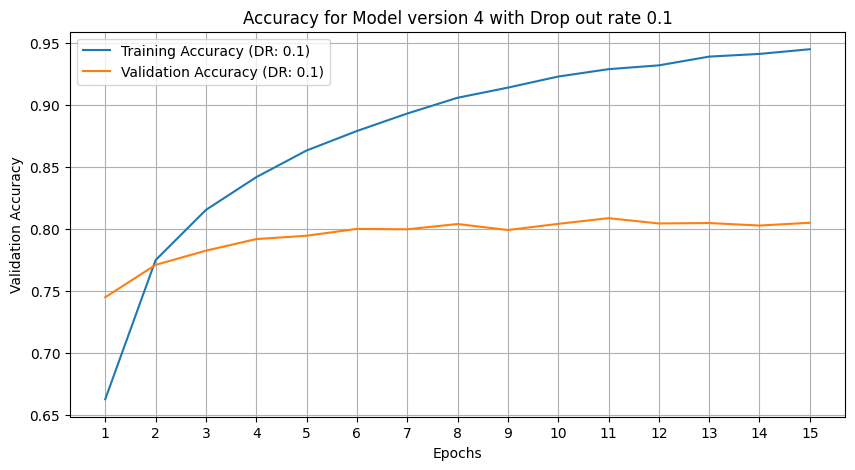

In [123]:
#Plotting training and validation accuracy for dropoutrate=0.1
dr=0.1
hist = scores[dr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (DR: {dr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (DR: {dr})')

plt.title(f'Accuracy for Model version 4 with Drop out rate {dr}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

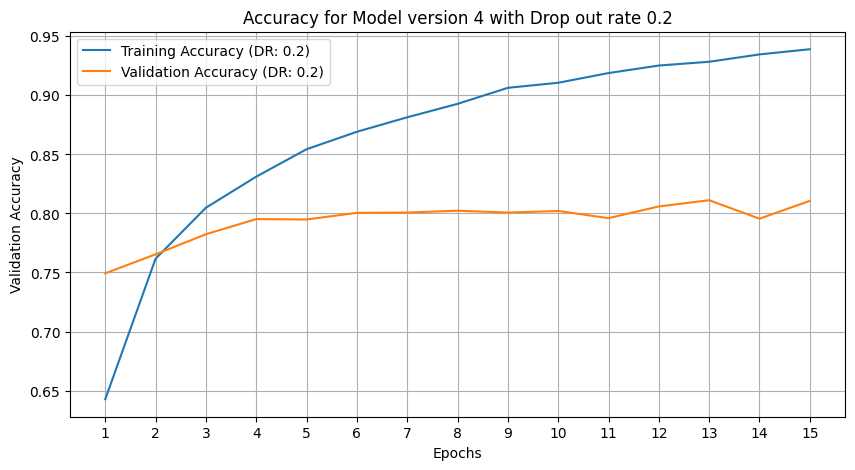

In [124]:
#Plotting training and validation accuracy for dropoutrate=0.2
dr=0.2
hist = scores[dr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (DR: {dr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (DR: {dr})')

plt.title(f'Accuracy for Model version 4 with Drop out rate {dr}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

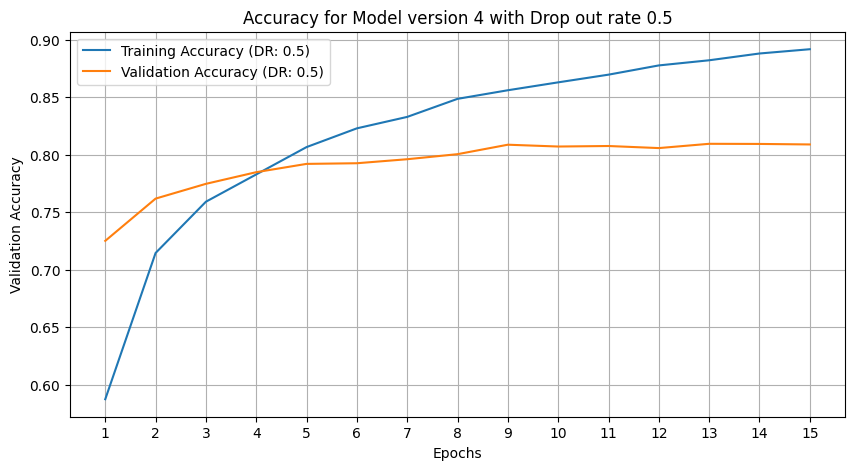

In [125]:
#Plotting training and validation accuracy for dropoutrate=0.5
dr=0.5
hist = scores[dr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (DR: {dr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (DR: {dr})')

plt.title(f'Accuracy for Model version 4 with Drop out rate {dr}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [126]:
#Building a summary with the results
best_models_info = {}

for droprate in scores.keys():
    best_val_accuracy = max(scores[droprate]['val_accuracy'])
    
    checkpoint_filename_pattern = f'Mobile_v4_droprate{droprate}_*_{best_val_accuracy:.3f}.keras'
    checkpoint_files = glob.glob(os.path.join(MODELS_DIR, checkpoint_filename_pattern))
    
    if checkpoint_files:
        best_models_info[droprate] = {
            'best_accuracy': best_val_accuracy,
            'checkpoint_file': checkpoint_files[0]  
        }
    else:
        print(f"No checkpoint files found for drop rate {droprate} with accuracy {best_val_accuracy:.3f}")

for droprate, info in best_models_info.items():
    print(f"Best model for drop rate {droprate}:")
    print(f"Best Validation Accuracy: {info['best_accuracy']:.3f}")
    print(f"Checkpoint file: {info['checkpoint_file']}")   

Best model for drop rate 0.0:
Best Validation Accuracy: 0.804
Checkpoint file: ../models/Mobile_v4_droprate0.0_11_0.804.keras
Best model for drop rate 0.01:
Best Validation Accuracy: 0.803
Checkpoint file: ../models/Mobile_v4_droprate0.01_13_0.803.keras
Best model for drop rate 0.1:
Best Validation Accuracy: 0.809
Checkpoint file: ../models/Mobile_v4_droprate0.1_11_0.809.keras
Best model for drop rate 0.2:
Best Validation Accuracy: 0.811
Checkpoint file: ../models/Mobile_v4_droprate0.2_13_0.811.keras
Best model for drop rate 0.5:
Best Validation Accuracy: 0.809
Checkpoint file: ../models/Mobile_v4_droprate0.5_14_0.809.keras


In [127]:
# Conclusion: The model overfits, but for dropout rate 0.5 there is a smaller gap between training and validation accuracy
#I will go with the rate 0.5 because even when it didn't get the highest accuracy, the accuracy improved a little compared to no drop rate at all
best_droprate=0.5
print(f"Best Validation Accuracy for 'Mobile version 3' model: {round(best_models_info[best_droprate]['best_accuracy'], 4)}")
print(f"Saved Model File: {best_models_info[best_droprate]['checkpoint_file']}")

Best Validation Accuracy for 'Mobile version 3' model: 0.8094
Saved Model File: ../models/Mobile_v4_droprate0.5_14_0.809.keras


In [130]:
#store results for model version 4
model_results['mobile_v4'] = {
    'accuracy': round(best_models_info[best_droprate]['best_accuracy'], 4),
    'filename': best_models_info[best_droprate]['checkpoint_file']
}

In [131]:
model_results['mobile_v4']

{'accuracy': 0.8094,
 'filename': '../models/Mobile_v4_droprate0.5_14_0.809.keras'}

### Training the model Mobile version 4 with augmentation

In [157]:
#declare a new generator for the train dataset
#the generator for the validation dataset is kept as before, the augmentations are applied to the training dataset only
#(the parameters set here were selected after some experimentation)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,               
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [158]:
#check size of images and batches
batch_images, batch_labels = next(train_gen)  
print("Batch shape for training:", batch_images.shape) 
print("Shape of training labels:", batch_labels.shape) 

batch_images, batch_labels = next(val_gen)  
print("Batch shape for validation:", batch_images.shape) 
print("Shape of validation labels:", batch_labels.shape) 

Batch shape for training: (16, 320, 320, 3)
Shape of training labels: (16, 128)
Batch shape for validation: (16, 320, 320, 3)
Shape of validation labels: (16, 128)


In [165]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v3_aug.*\.keras')
print(f'\nTraining the model v4 with augmentation\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v4_aug_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

learning_rate=0.001
inner_layer_size=1280
l2_factor=0.0001
droprate=0.3

model = make_model_Mobile_v4(learning_rate=learning_rate, inner_layer_units= inner_layer_size, 
                                 l2_factor=l2_factor, droprate=droprate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)


Deleting files previously saved to output directory

No matching files found for deletion.

Training the model v4 with augmentation

Epoch 1/20
New best model saved at epoch 1 with validation accuracy 0.767.Filename:../models/Mobile_v4_aug_01_0.767.keras2  
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 172s 97ms/step - accuracy: 0.6170 - loss: 1.6710 - val_accuracy: 0.7665 - val_loss: 0.8875
Epoch 2/20
New best model saved at epoch 2 with validation accuracy 0.782.Filename:../models/Mobile_v4_aug_02_0.782.keras2   
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 137s 82ms/step - accuracy: 0.7641 - loss: 0.9022 - val_accuracy: 0.7822 - val_loss: 0.8433
Epoch 3/20
New best model saved at epoch 3 with validation accuracy 0.803.Filename:../models/Mobile_v4_aug_03_0.803.keras3  
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 145s 87ms/step - accuracy: 0.7848 - loss: 0.8043 - val_accuracy: 0.8032 - val_loss: 0.7865
Epoch 4/20
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 128s 77ms/step - accuracy: 0.8022 - loss: 0.7608 - val_accuracy: 0.7962 - val_loss:

KeyboardInterrupt: 

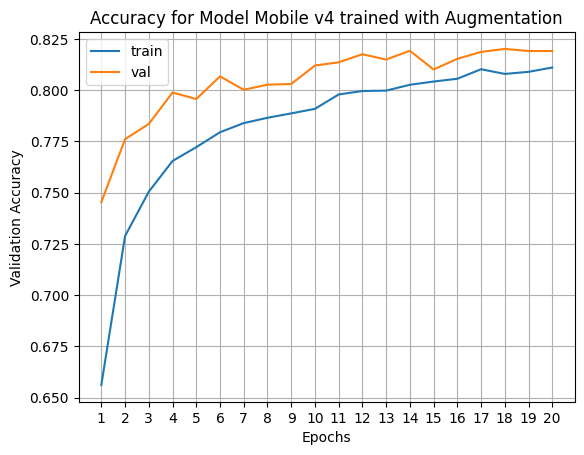

In [167]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.title('Accuracy for Model Mobile v4 trained with Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

num_epochs = len(history.history['val_accuracy'])  
plt.xticks(np.arange(num_epochs), np.arange(1, num_epochs + 1)) 
plt.legend()
plt.grid()
plt.show()

In [136]:
##Conclusion: there is a small improvement by training the model 4 with augmentation

In [87]:
model_results['mobile_v4_with_augmentation'] = {
    'accuracy': round(custom_checkpoint.best_accuracy, 4),
    'filename': custom_checkpoint.best_model_file
}
print(f"Best Validation Accuracy for 'Mobile version 4 with Augmentation' model: {model_results['mobile_v4_with_augmentation']['accuracy']}")
print(f"Saved Model File: {model_results['mobile_v4_with_augmentation']['filename']}")

Best Validation Accuracy for 'Mobile version 4 with Augmentation' model: 0.8225
Saved Model File: ../models/Mobile_v4_aug_10_0.822.keras


In [ ]:
#Conclusion: I will go with the version 4 of the model, trained without augmentation for 10 epochs
best_model_name='mobile_v4_with_augmentation'

In [ ]:
# Calculate time it took to run the notebook
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = round(total_time_seconds / 60)

print(f"Total execution time for this notebook: {total_time_minutes} minutes")